In [53]:
#ライブラリのインポート
import glob
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import df_pre as df_pre
import optuna

#lgb用
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as o_lgb

#警告を非表示
import warnings
warnings.simplefilter('ignore')

In [54]:
#ファイルの読み込み
files = glob.glob("../../data/train/*.csv")
data_list = []
for file in files:
    data_list.append(pd.read_csv(file, index_col=0))
data_list
df = pd.concat(data_list)

In [55]:
#変換処理の適用
df = df_pre.data_pre(df)
df

test


,市区町村コード,都道府県名_num,地区名,最寄駅：名称,最寄駅：距離（分）_min,間取り,面積（㎡）_num,建築年_year,建物の構造_num,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点_num,改装,取引の事情等,取引価格（総額）_log
ID,,,,,,,,,,,,,,,,,,
1088170,1204,18,７条通,旭川,16.0,２ＤＫ,45,33.0,5.0,住宅,NaN,近隣商業地域,80.0,300.0,2011.99,未改装,NaN,6.740363
1048405,1106,18,真駒内柏丘,真駒内,25.0,３ＬＤＫ,70,30.0,5.0,住宅,住宅,第１種住居地域,60.0,200.0,2017.50,改装済,NaN,6.875061
1030233,1104,18,菊水１条,菊水,6.0,４ＬＤＫ,105,14.0,5.0,NaN,住宅,第１種住居地域,60.0,200.0,2020.50,未改装,NaN,7.518514
1000080,1101,18,大通西,西１１丁目,4.0,３ＬＤＫ,100,17.0,5.0,住宅,住宅,商業地域,80.0,600.0,2019.99,未改装,NaN,7.792392
1065071,1108,18,大谷地東,ひばりが丘(北海道),9.0,３ＬＤＫ,75,15.0,5.0,住宅,NaN,近隣商業地域,80.0,300.0,2009.50,未改装,NaN,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47014161,47208,11,勢理客,NaN,NaN,３ＬＤＫ,70,20.0,5.0,住宅,NaN,第１種住居地域,60.0,200.0,2010.50,未改装,NaN,7.255273
47027826,47208,11,牧港,NaN,NaN,３ＬＤＫ,65,24.0,5.0,住宅,NaN,準工業地域,60.0,200.0,2013.99,改装済,NaN,7.278754
47003754,47208,11,港川,NaN,NaN,３ＬＤＫ,65,17.0,5.0,NaN,その他,商業地域,80.0,400.0,2018.50,改装済,NaN,7.397940


In [56]:
#trainデータの用意
col = "取引価格（総額）_log"
train_y = df[col]
train_x = df.drop(col, axis=1)

In [57]:
type(train_x)

pandas.core.frame.DataFrame

In [65]:
#クロスバリデーション_lgb_kaggleで勝つデータ分析の技術_kaggleのチュートリアル

#バリデーション用パラメータ変数
FOLD = 5
NUM_ROUND = 300
VERBOSE_EVAL = -1

#LGB用のパラメータ設定
params = {
    "objective": "regression",
    "metrics": "mae",
    "verbose": -1
}

#各種リスト
valid_scores = []
evaluation_results = {}
models = []

#データ分析の技術_kaggleのチュートリアルより
kf = KFold(n_splits=FOLD, shuffle=True, random_state = 42)
for (tr_idx, va_idx) in kf.split(train_x, train_y):
    tr_x = train_x.iloc[tr_idx]
    va_x = train_x.iloc[va_idx]
    tr_y = train_y.iloc[tr_idx]
    va_y = train_y.iloc[va_idx]

    #LGB用のモデルの作成
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)
    categorical_features = ["地区名", "最寄駅：名称", "間取り", "用途", "今後の利用目的", "都市計画", "改装", "取引の事情等"]
    
    #モデルの学習を行う
    model = lgb.train(
        params, 
        lgb_train, 
        valid_sets=lgb_eval,
        valid_names=['train', 'valid'],
        evals_result=evaluation_results,
                  num_boost_round=NUM_ROUND,
                  early_stopping_rounds=100,
        verbose_eval=VERBOSE_EVAL,
                  categorical_feature = categorical_features)
   
    y_valid_pred = model.predict(va_x)
    score = mae(va_y, y_valid_pred)
    print(f'MAE: {score}')
    valid_scores.append(score)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	train's l1: 0.0765665
MAE: 0.07656654620545104
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	train's l1: 0.0762549
MAE: 0.07625495164770711
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	train's l1: 0.0768666
MAE: 0.0768665974734705
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	train's l1: 0.0764167
MAE: 0.07641673407246613
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0766649
MAE: 0.07666489778413998
CV score: 0.07655394543664695


In [66]:
evaluation_results

{'train': OrderedDict([('l1',
               [0.2528685733290074,
                0.2367986158686568,
                0.2225632223192791,
                0.21014624055172904,
                0.19896481369854213,
                0.18884248007880816,
                0.1800317022851917,
                0.17234675779512645,
                0.16540234531496012,
                0.15944266537702645,
                0.15398251362676482,
                0.14902377893295923,
                0.14484569593693603,
                0.14093491293411226,
                0.13760906216450847,
                0.13411175937025033,
                0.1313491005153603,
                0.12864405854598,
                0.12633916165707917,
                0.12408122889379916,
                0.12209003044796081,
                0.11996963701870773,
                0.11797829254206879,
                0.11638683256956113,
                0.11478430018932871,
                0.11310653724253882,
                

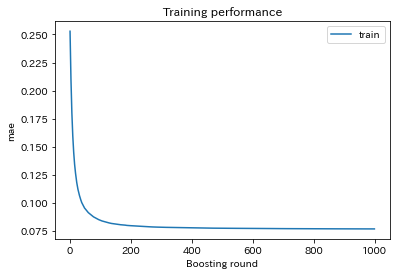

In [67]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['l1'], label='train')
plt.ylabel('mae')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
#plt.savefig('cv_logloss.jpg')
plt.show()

In [68]:
#提出用データ作業
df_test = pd.read_csv("../../data/test.csv", index_col=0)
df_test = df_pre.data_pre(df_test)
df_test = df_test.drop(columns="取引価格（総額）_log", axis=1)

#結果格納用のデータフレーム
df_pred_result = pd.DataFrame(index=[], columns=[1, 2, 3, 4, 5])
a=1
for model in models:
    predict = model.predict(df_test)
    df_pred_result[a] = predict
    a = a+1
df_test["取引価格（総額）_log"] = df_pred_result.mean(axis='columns').to_numpy()
df_test[["取引価格（総額）_log"]].to_csv("../../data/submit_test.csv")

test


In [63]:
df_pred_result.mean(axis='columns').to_numpy().shape

(22395,)

In [64]:
df_pred_result

,1,2,3,4,5
0,7.121227,7.071112,7.100024,7.035489,7.055972
1,7.245924,7.227134,7.254695,7.199584,7.175754
2,7.522665,7.507436,7.541739,7.543990,7.501919
3,6.933817,6.956141,6.937419,6.937024,6.936096
4,7.001648,7.002598,6.980932,6.990485,7.015011
...,...,...,...,...,...
22390,7.561521,7.564981,7.562922,7.551639,7.559547
22391,7.478298,7.450846,7.468398,7.476711,7.447548
22392,7.411009,7.393142,7.394202,7.404697,7.396398
22393,7.375755,7.394717,7.420810,7.410079,7.383979


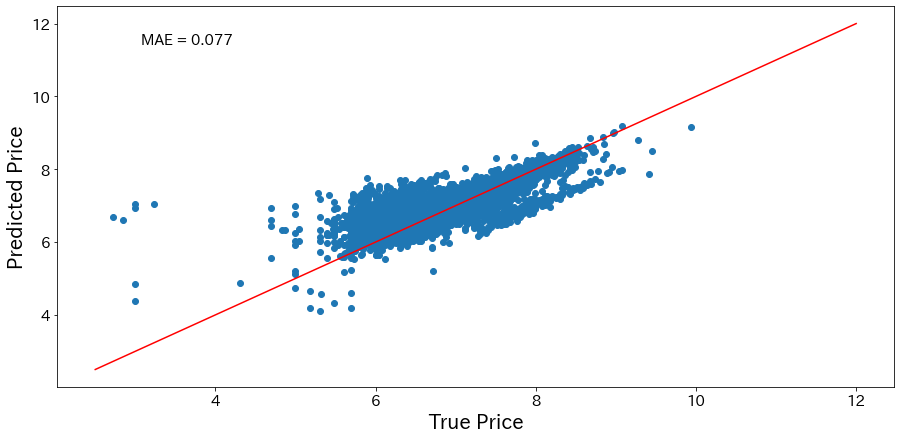

In [64]:
#予測精度の確認（視覚化）
def Prediction_accuracy(val_y, va_pred):
    predicted_df = pd.DataFrame(index=[], columns=["pred", "true"])
    predicted_df["true"] = val_y.values   #val_yがSeries型のため、np配列ndarrayに変換処理をしてから入れる
    predicted_df["pred"] = va_pred
    score_mae = mae(test_data1["pred"], test_data1["true"])
    
    plt.figure(figsize = (15,7))
    ax = plt.subplot(1, 1, 1)
    ax.scatter('true', 'pred', data = predicted_df)
    ax.set_xlabel('True Price', fontsize = 20)
    ax.set_ylabel('Predicted Price', fontsize = 20)
    plt.tick_params(labelsize = 15)
    x = np.linspace(2.5, 12)
    y = x
    ax.plot(x, y, 'r-')
    plt.text(0.1, 0.9, 'MAE = {}'.format(str(round(score_mae,3))),transform = ax.transAxes, fontsize = 15)
    
Prediction_accuracy(val_y, va_pred)

In [6]:
#提出用データ作業
df_test = pd.read_csv("../data/test.csv", index_col=0)
df_test = df_pre.data_pre(df_test)
df_test = df_test.drop(columns="取引価格（総額）_log", axis=1)

predict = model.predict(df_test)
df_test["取引価格（総額）_log"] = predict
df_test[["取引価格（総額）_log"]].to_csv("../../data/submit_test.csv")



test


In [6]:
#要素の重要度を確認
pd.DataFrame(model.feature_importance(), index=val_x.columns, columns=["importance"]).sort_values("importance", ascending=False)

,importance
地区名,8621
最寄駅：名称,6414
建築年_year,3339
取引時点_num,3196
面積（㎡）_num,2025
最寄駅：距離（分）_min,1757
間取り,918
市区町村コード,827
都道府県名_num,653
改装,489


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

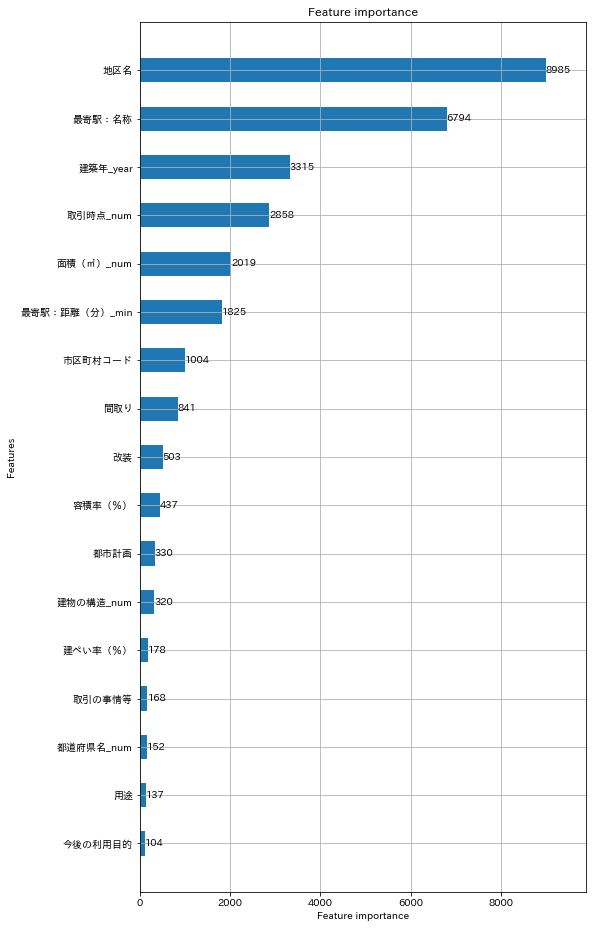

In [8]:
#要素の重要度を可視化
lgb.plot_importance(model, height = 0.5, figsize = (8,16))

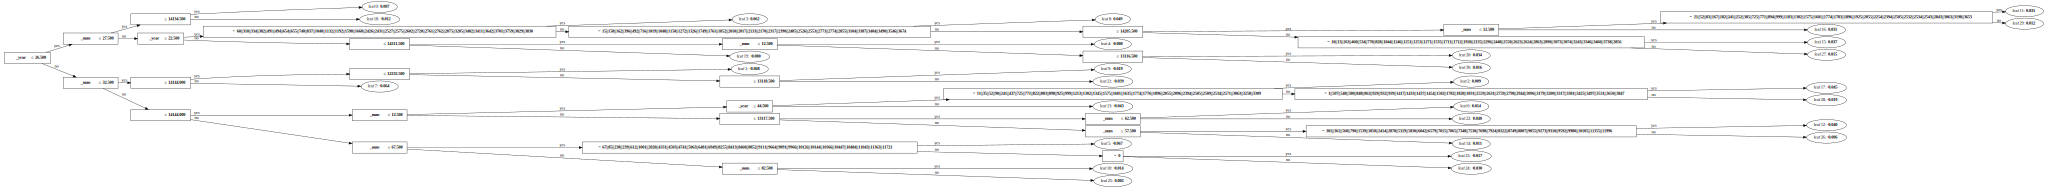

In [9]:
#要素の重要度を樹形図で表示
lgb.create_tree_digraph(model, 1)

In [5]:
#チューニング用データ処理
df_train, df_val =train_test_split(df, test_size=0.2)

col = "取引価格（総額）_log"
train_y = df_train[col]
train_x = df_train.drop(col, axis=1)

val_y = df_val[col]
val_x = df_val.drop(col, axis=1)

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(val_x, val_y)

In [27]:
#LightGBMパラメータの最適化
def objective(trial):
    params = {'metric': {'mae'},
              'max_depth' : trial.suggest_int('max_depth', 1, 10),
              #'subsumple' : trial.suggest_uniform('subsumple', 0.0, 1.0),
              'subsample_freq' : trial.suggest_int('subsample_freq', 0, 1),
              #'leaning_rate' : trial.suggest_loguniform('leaning_rate', 1e-5, 1),
              'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.0, 1.0),
              'lambda_l1' : trial.suggest_uniform('lambda_l1' , 0.0, 1.0),
              'lambda_l2' : trial.suggest_uniform('lambda_l2' , 0.0, 1.0)}
 
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=100,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    predicted = gbm.predict(val_x)
    MAE = mae(val_y, predicted)
    
    #pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'mae')
    return MAE

In [28]:
study = optuna.create_study()
study.optimize(objective, timeout=3600)

[I 2022-01-03 20:51:55,495] A new study created in memory with name: no-name-b014b030-9b4e-4552-a6f8-e99d85143440
[I 2022-01-03 20:51:55,497] A new study created in memory with name: no-name-e2377d82-60bb-4a5f-897a-b95e91603f5c










  0%|                                                                                            | 0/7 [00:00<?, ?it/s]









feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\user\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\user\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future r

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11732
[LightGBM] [Info] Number of data points in the train set: 554305, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.224269


C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 0.0972599












feature_fraction, val_score: 0.086883:   0%|                                                     | 0/7 [00:04<?, ?it/s]









feature_fraction, val_score: 0.086883:  14%|######4                                      | 1/7 [00:04<00:29,  4.95s/it][W 2022-01-03 20:52:00,449] Trial 0 failed because of the following error: TypeError('Object of type set is not JSON serializable')
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\user\anaconda3\lib\site-packages\optuna\integration\_lightgbm_tuner\optimize.py", line 265, in __call__
    self._postprocess(trial, elapsed_secs, average_iteration_time)
  File "C:\Users\user\anaconda3\lib\site-packages\optuna\integration\_lightgbm_tuner\optimize.py", line 279, in _postprocess
    trial.set_system_attr(_LGBM_PARAMS_KEY, json.dumps(self.lgbm_params))
  File "C:\Users\user\anaconda3\lib\json\__init__.py

[100]	valid_0's l1: 0.0868832
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.0868832


TypeError: Object of type set is not JSON serializable

In [ ]:
print('Best trial:')
trial = study.best_trial
print('Value:{}'.format(trial.value))
print('Params:')
for key, value in trial.params.items():
    print('"{}" : {}'.format(key, value))

In [9]:
score = mae(val_y, va_pred)

NameError: name 'va_pred' is not defined